In [1]:
import micrograd
from micrograd.engine import Tensor
import micrograd.nn as nn
import micrograd.functional as F
from micrograd.optim import SGD, Adam
from micrograd.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

In [2]:
def mask_scores(attn_scores):
    """
    Args:
        attn_scores: Tensor of shape (batch_size, num_heads, seq_len, seq_len)
    Returns:
        out: Tensor of shape (batch_size, num_heads, seq_len, seq_len)
    """
    seq_len = attn_scores.shape[-2]
    neg_inf = Tensor(np.array(-1e9))
    q_ind = np.expand_dims(np.arange(seq_len), 1)
    k_ind = np.expand_dims(np.arange(seq_len), 0)
    mask = Tensor(q_ind < k_ind)
    attn_scores = micrograd.where(mask, neg_inf, attn_scores)
    return attn_scores

In [3]:
def masked_attn(q, k, v):
    """
    Args:
        - q: Tensor of shape (batch_size, num_heads, seq_len, headsize)
        - k: Tensor of shape (batch_size, num_heads, seq_len, headsize)
        - v: Tensor of shape (batch_size, num_heads, seq_len, headsize)
    Returns:
        - out: Tensor of shape (batch_size, num_heads, seq_len, headsize)
    """
    headsize = q.shape[-1]
    attn_scores = q.matmul(k.transpose(-1, -2)) / Tensor(np.sqrt(headsize))
    attn_scores = mask_scores(attn_scores)
    attn_scores = attn_scores.softmax(dim=-1)
    out = attn_scores.matmul(v)
    return out

In [4]:
class MaskedMultiHeadedAttn(nn.Module):
    def __init__(self, num_heads, hidden_size):
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.out_proj = nn.Linear(hidden_size, hidden_size)

        self.num_heads = num_heads
        assert hidden_size % num_heads == 0
        self.headsize = hidden_size // self.num_heads
    
    def __call__(self, x):
        """
        Args:
            - x: Tensor of shape (batch_size, seq_len, hidden_size)
        Returns:
            - out: Tensor of shape (batch_size, seq_len, hidden_size)
        """
        batch_size, seq_len, hidden_size = x.shape
        q = self.q_proj(x).reshape((batch_size, seq_len, self.num_heads, self.headsize,)).transpose(1, 2)
        k = self.k_proj(x).reshape((batch_size, seq_len, self.num_heads, self.headsize,)).transpose(1, 2)
        v = self.v_proj(x).reshape((batch_size, seq_len, self.num_heads, self.headsize,)).transpose(1, 2)
        out = masked_attn(q, k, v)
        out = out.transpose(1, 2).reshape((batch_size, seq_len, -1,))
        out = self.out_proj(out)
        return out

In [5]:
class DecoderBlock(nn.Module):
    def __init__(self, num_heads, hidden_size):
        self.attn = MaskedMultiHeadedAttn(num_heads, hidden_size)
        self.ln1 = nn.LayerNorm((hidden_size,))
        self.ln2 = nn.LayerNorm((hidden_size,))
        self.lin1 = nn.Linear(hidden_size, hidden_size * 4)
        self.lin2 = nn.Linear(hidden_size * 4, hidden_size)
    
    def __call__(self, x):
        """
        Args:
            - x : torch.tensor of shape (batch_size, seq_len, hidden_size)
        Returns:
            - out: torch.tensor of shape (batch_size, seq_len, hidden_size)
        """
        x = x + self.attn(self.ln1(x))
        x = x + self.lin2(self.lin1(self.ln2(x)).relu())
        return x

In [6]:
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, max_pos_embeddings, num_heads, hidden_size, num_layers):
        self.token_embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_embedding = nn.Embedding(max_pos_embeddings, hidden_size)
        self.blocks = nn.Sequential(
            *[
                DecoderBlock(num_heads, hidden_size)
                for _ in range(num_layers)
            ]
        )
        self.ln = nn.LayerNorm((hidden_size,))
        self.lm_head = nn.Linear(hidden_size, vocab_size)

    
    def __call__(self, input_ids):
        """
        Args: 
            - input_ids : torch.tensor of shape (batch_size, seq_len)
        Returns:
            - logits: torch.tensor of shape (batch_size, seq_len, vocab_size)
        """
        batch_size, seq_len = input_ids.shape
        pos = Tensor(np.arange(seq_len))
        x = self.token_embedding(input_ids) + self.pos_embedding(pos)
        x = self.blocks(x)
        x = self.ln(x)
        out = self.lm_head(x)
        return out

Training on toy addition task (taken from Karpathy's minGPT)

In [7]:
class AdditionDataset(Dataset):
    """
    Creates n-digit addition problems. For example, if n=2, then an example
    addition problem would be to add 85 + 50 = 135. This problem would be
    represented as the following string for the GPT:
    "8550531"
    This is because:
    - we are discarding the + and =, which are not necessary. We just encode the digits
      of the input numbers concatenated together.
    - the result 135 is encoded backwards to make the addition easier to learn for the
      GPT model, because of how the addition algorithm works.
    As one more example, the problem 6 + 39 = 45 would be encoded as:
    "0639054"
    where you will notice that we are padding with zeros to make sure that we always
    produce strings of the exact same size: n + n + (n + 1). When n=2, this is 7.
    At test time, we will feed in an addition problem by giving the first 2n digits,
    and hoping that the GPT model completes the sequence with the next (n+1) digits
    correctly.
    """

    def __init__(self, ndigit, split):
        self.ndigit = ndigit
        self.split = split # train/test

        # split up all addition problems into either training data or test data
        assert ndigit <= 3, "the lines below would be very memory inefficient, in future maybe refactor to support"
        num = (10**ndigit)**2 # total number of possible addition problems with ndigit numbers
        perm = np.random.permutation(num)
        num_test = min(int(num*0.2), 500) # 20% of the whole dataset, or only up to 500
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]

    def get_vocab_size(self):
        return 10 # digits 0..9

    def get_block_size(self):
        # a,b,a+b, and +1 due to potential carry overflow,
        # but then also -1 because very last digit doesn't ever plug back
        # as there is no explicit  token to predict, it is implied
        return 3*self.ndigit + 1 - 1

    def __len__(self):
        return self.ixes.size

    def __getitem__(self, idx):
        ndigit = self.ndigit
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx].item()
        nd = 10**ndigit
        a = idx // nd
        b = idx %  nd
        # calculate the "label" of the addition problem a + b
        c = a + b
        # encode the digits of a, b, c into strings
        astr = f'%0{ndigit}d' % a
        bstr = f'%0{ndigit}d' % b
        cstr = (f'%0{ndigit+1}d' % c)[::-1] # reverse c to make addition easier
        render = astr + bstr + cstr
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = np.array(dix[:-1], dtype=int)
        y = np.array(dix[1:], dtype=int) # predict the next token in the sequence
        y[:ndigit*2-1] = -1 # we will only train in the output locations. -1 will mask loss to zero
        return Tensor(x), Tensor(y)

train_dataset = AdditionDataset(2, 'train')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

In [9]:
model = DecoderOnlyTransformer(
    vocab_size=train_dataset.get_vocab_size(),
    max_pos_embeddings=train_dataset.get_block_size(),
    num_heads=3,
    hidden_size=48,
    num_layers=3
)
optimizer = Adam(model.parameters(), lr=5e-4)

losses = []

max_epochs = 10
for epoch in range(max_epochs):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for it, (x, y) in pbar:
        logits = model(x)

        optimizer.zero_grad()
        loss = F.batched_cross_entropy(logits.reshape((-1, logits.shape[-1],)), y.reshape(-1), ignore_index=-1)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"epoch: {epoch}, it: {it}, loss: {loss.data.item():.5f}")
        losses.append(loss.data.item())

epoch: 9, it: 148, loss: 0.00371: 100%|███████████████████████████████████████████████████| 149/149 [00:20<00:00,  7.29it/s]


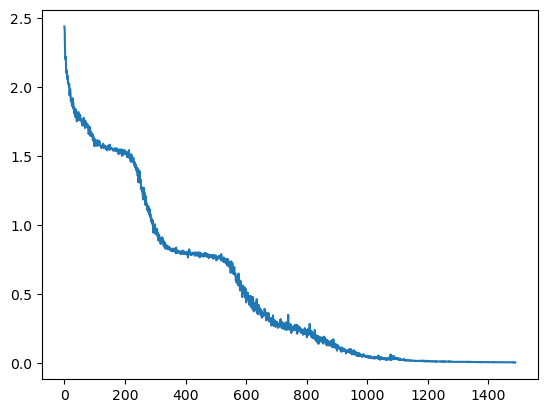

In [10]:
# plot loss curve
import matplotlib.pyplot as plt

plt.plot(losses);